In [942]:
import pandas as pd
import numpy as np
import tweepy
import requests
import matplotlib.pyplot as plt
from tweepy import OAuthHandler
import json

### Gathering Data

Gather each of the three pieces of data as described below in a Jupyter Notebook titled wrangle_act.ipynb:

- The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: twitter_archive_enhanced.csv

- The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

- Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

### Fetching data from the given file - twitter-archive-enhanced.csv

In [943]:
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [944]:
# peruse the dataframe
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [945]:
tweet_ids = archive.tweet_id.values
len(tweet_ids)

2356

### Downloading the image prediction file, image_predictions.tsv from the given link.

In [946]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image = requests.get(url, allow_redirects=True)

open('image_predictions.tsv', 'wb').write(image.content)

335079

In [947]:
# View the data in the image prediction file
image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Query Twitter API for each tweetId in the Twitter archive and save JSON in a text file

In [948]:
# These are hidden to comply with Twitter's API terms and conditions

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


In [949]:
api

#### The code as given in twitter-api.py

In [ ]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            #json.dump(tweet._json, outfile, indent=4)
            outfile.write('\n')
        except tweepy.TweepError as e:
            fails_dict[tweet_id] = e
            pass

In [1064]:
print("Number of tweets found is ",count)
print("Number of tweets not found is ",len(fails_dict))

NameError: name 'count' is not defined

### Get the data from tweet_json.txt into a data frame
Ref: https://knowledge.udacity.com/questions/280182

In [1066]:
# Save the retweet and favorite counts for each tweetID in a new data frame

tweet_details = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count', 'retweeted_status'])
with open ('tweet_json.txt', encoding='utf-8') as f:
    for line in f:
        status = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        retweeted_status = status['retweeted_status'] = status.get('retweeted_status', 'original')
        if retweeted_status == 'original':
            url = 'original'
        else:
            retweeted_status = 'retweet'
            url = 'retweet'
            
        tweet_details = tweet_details.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count, retweeted_status]], 
                                    columns=['tweet_id', 'retweet_count', 'favorite_count', 'retweeted_status']))

In [1067]:
# resetting index
tweet_details = tweet_details.reset_index(drop=True)

### Assessing Data

Key points to keep in mind when data wrangling for this project:

- You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
- Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
- Cleaning includes merging individual pieces of data according to the rules of tidy data.
- The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
- You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

### Visual Assessment
Each piece of gathered data is displayed.

In [1068]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [1069]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [1070]:
tweet_details

,tweet_id,retweet_count,favorite_count,retweeted_status
0,892420643555336193,7277,34736,original
1,892177421306343426,5445,30115,original
2,891815181378084864,3585,22665,original
3,891689557279858688,7466,38002,original
4,891327558926688256,8030,36278,original
...,...,...,...,...
2325,666049248165822465,37,92,original
2326,666044226329800704,120,255,original
2327,666033412701032449,38,105,original
2328,666029285002620928,41,117,original


### Programmatic assessment

### Twitter Archive programmatic assessment

In [1071]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [1072]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [1073]:
archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [1074]:
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [1075]:
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [1076]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [1077]:
archive.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
Jersey       1
Zara         1
Anthony      1
Vixen        1
Rizzo        1
Name: name, Length: 957, dtype: int64

In [1078]:
archive.query('name == name.str.lower()').name

22       such
56          a
118     quite
169     quite
193     quite
        ...  
2349       an
2350        a
2352        a
2353        a
2354        a
Name: name, Length: 109, dtype: object

In [1079]:
archive.doggo.value_counts(), archive.floofer.value_counts(),archive.pupper.value_counts(),archive.puppo.value_counts() 

(None     2259
 doggo      97
 Name: doggo, dtype: int64,
 None       2346
 floofer      10
 Name: floofer, dtype: int64,
 None      2099
 pupper     257
 Name: pupper, dtype: int64,
 None     2326
 puppo      30
 Name: puppo, dtype: int64)

### Image_predictions programmatic assessment

In [1080]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [1081]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [1082]:
image_predictions.tweet_id.duplicated().sum()

0

In [1083]:
image_predictions.jpg_url.duplicated().sum()

66

In [1084]:
image_predictions.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
envelope                1
guenon                  1
leopard                 1
restaurant              1
bakery                  1
Name: p1, Length: 378, dtype: int64

In [1085]:
image_predictions.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
confectionery           1
toaster                 1
shower_curtain          1
nail                    1
snail                   1
Name: p2, Length: 405, dtype: int64

In [1086]:
image_predictions.p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
chimpanzee             1
binder                 1
desktop_computer       1
nail                   1
snail                  1
Name: p3, Length: 408, dtype: int64

### Tweet Details programmatic assessment

In [1087]:
tweet_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2330 non-null   object
 1   retweet_count     2330 non-null   object
 2   favorite_count    2330 non-null   object
 3   retweeted_status  2330 non-null   object
dtypes: object(4)
memory usage: 72.9+ KB


In [1088]:
tweet_details.retweeted_status.value_counts()

original    2168
retweet      162
Name: retweeted_status, dtype: int64

In [1089]:
tweet_details.retweet_count.value_counts()

431     6
211     5
1867    4
80      4
330     4
       ..
2620    1
1233    1
2618    1
1237    1
1       1
Name: retweet_count, Length: 1672, dtype: int64

In [1090]:
tweet_details.favorite_count.value_counts()

0       162
1804      4
2525      3
1201      3
2520      3
       ... 
2538      1
639       1
2544      1
2547      1
5987      1
Name: favorite_count, Length: 1985, dtype: int64

### Cleaning Data

### Quality Issues -

### Twitter_archive :
#### 1. Completeness:
    - Remove the columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls due to the missing data and are not needed for the analysis.
#### 2. Validity:
    - Delete retweets, Select only rows that have null values in retweet related columns, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns.
    - Select invalid dog names, which most probably starts with lower case letters and "none" to np.nan.
#### 3. Accuracy:
    - Change the timestamp from object data type to correct datetime format.


### Image_Prediction :
#### 4. Completeness:
    - As the column img_num is not needed for the analysis hence removed it.
#### 5. Validity:
    - Some image prediction data, p1 and p2 and p3 predictions have invalid dog names like nail, snail, desktop_computer. Remove images that are not dogs.
#### 6. Accuracy:
    - Delete duplicated url.


### Tweet_Details :
#### 7. Completeness:
    - Remove the column retweeted_status as it was not needed for the analysis.
#### 8. Validity:
    - There are 162 retweets. Keep only original tweets.
#### 9. Consistency:
    - Change tweet_id, retweet_count, favorite_count from Object data type to int 64.

    
###   Tidiness Issues -
1. Twitter_archive - There are four columns namely doggo, floofer,puppo, pupper for the stages of a particular dog. I combine all four columns into single column with name dog_stage.
2. I merge all the three datasets collected from different sources into a single dataset and save it in a file called twitter_archive_master.csv


### Copies of the original pieces of data are made prior to cleaning.

In [1091]:
archive_clean = archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_details_clean = tweet_details.copy()

### Twitter archive cleaning

#### 1. Define -  Delete retweets, Select only rows that have null values in retweet related columns, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns.

Referred: https://knowledge.udacity.com/questions/593687

In [1092]:
archive_clean[['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   retweeted_status_id         181 non-null    float64
 1   retweeted_status_user_id    181 non-null    float64
 2   retweeted_status_timestamp  181 non-null    object 
dtypes: float64(2), object(1)
memory usage: 55.3+ KB


In [1093]:
# Code 
archive_clean = archive_clean[np.isnan(archive_clean.retweeted_status_id)]

In [1094]:
# Test
archive_clean[['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   retweeted_status_id         0 non-null      float64
 1   retweeted_status_user_id    0 non-null      float64
 2   retweeted_status_timestamp  0 non-null      object 
dtypes: float64(2), object(1)
memory usage: 68.0+ KB


#### 2. Define : Delete columns that will not be used.

In [1095]:
# Code : Deleting columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,\
#        retweeted_status_user_id, retweeted_status_timestamp, expanded_urls

archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
            'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], axis=1, inplace=True)

In [1096]:
# Test: Checking if the columns are deleted.
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   rating_numerator    2175 non-null   int64 
 5   rating_denominator  2175 non-null   int64 
 6   name                2175 non-null   object
 7   doggo               2175 non-null   object
 8   floofer             2175 non-null   object
 9   pupper              2175 non-null   object
 10  puppo               2175 non-null   object
dtypes: int64(3), object(8)
memory usage: 203.9+ KB


#### 3. Define : Change the data type of timestamp from string to datetime.

In [1097]:
#Code to change the datatype
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

In [1098]:
# Test if the timestamp has datetime datatype
archive_clean.timestamp.dtypes

datetime64[ns, UTC]

#### 4. Define : Combine the columns doggo, floofer, pupper, puppo into a single column dog_stage.
    1. In doggo column, replace None with empty string.
    2. Repeat step 1 for floofer, pupper and puppo columns.
    3. Combine all the columns doggo, floofer, pupper, puppo into a single column dog_stage.
    4. Clearly seperate the names for multiple stages like in doggopupper as doggo, pupper.
    5. Replace empty strings into np.nan values.
    6. Drop the columns doggo, floofer, pupper, puppo.

- Referred : https://knowledge.udacity.com/questions/167565

In [1099]:
# 1. & 2. code 
# handle None
archive_clean.doggo.replace('None', '', inplace=True)
archive_clean.floofer.replace('None', '',  inplace=True)
archive_clean.pupper.replace('None', '',  inplace=True)
archive_clean.puppo.replace('None', '',  inplace=True)

In [1100]:
#Test
archive_clean.head(3)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,,,,
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,,,,
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,,,,


In [1101]:
# 3.code
# merge into column
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

In [1102]:
#test
archive_clean.dog_stage.value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [1103]:
# 4. Code 
# handle multiple stages
archive_clean.loc[archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
archive_clean.loc[archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
archive_clean.loc[archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [1104]:
#test
archive_clean.dog_stage.value_counts()

                  1831
pupper             224
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, floofer       1
doggo, puppo         1
Name: dog_stage, dtype: int64

In [1105]:
# 5.Code 
# handle missing values
archive_clean.loc[archive_clean.dog_stage == '', 'dog_stage'] = np.nan

In [1106]:
#test
archive_clean.dog_stage.value_counts()

pupper            224
doggo              75
puppo              24
doggo, pupper      10
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: dog_stage, dtype: int64

In [1107]:
# 6. Code 
# Drop the columns
archive_clean.drop(['doggo','floofer','pupper','puppo'],axis=1, inplace=True)

In [1108]:
#test
archive_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN


#### 5. Define - Select invalid dog names, which most probably starts with lower case letters and "none" to np.nan

In [1109]:
#Code 
archive_clean.loc[archive_clean.name == archive_clean.name.str.lower(), 'name'] = np.nan
archive_clean.loc[archive_clean.name == 'None', 'name'] = np.nan

In [1110]:
#Test
archive_clean.query('name == name.str.lower()').name

Series([], Name: name, dtype: object)

In [1111]:
#Test
archive_clean.name.value_counts()

Charlie    11
Lucy       11
Cooper     10
Oliver     10
Penny       9
           ..
Grizz       1
Kenzie      1
Grey        1
Rontu       1
Rizzo       1
Name: name, Length: 930, dtype: int64

In [1112]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   rating_numerator    2175 non-null   int64              
 5   rating_denominator  2175 non-null   int64              
 6   name                1391 non-null   object             
 7   dog_stage           344 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 152.9+ KB


### Image_Prediction Cleaning

In [1113]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### 6. Define - Delete duplicated url

In [1114]:
image_predictions_clean.jpg_url.duplicated().sum()

66

In [1115]:
#code
image_predictions_clean = image_predictions_clean.drop_duplicates(subset=['jpg_url'], keep='last')

In [1116]:
#Test
image_predictions_clean.jpg_url.duplicated().sum()

0

#### 7. Remove images that are not dogs.

Referred: https://knowledge.udacity.com/questions/237780

In [1117]:
image_predictions_clean.query('p1_dog==False and p2_dog==False and p3_dog==False').shape[0]

318

In [1118]:
# Code
image_predictions_clean= image_predictions_clean.query('p1_dog==True and p2_dog==True and p3_dog==True')

In [1119]:
# Test
image_predictions_clean.query('p1_dog==False and p2_dog==False and p3_dog==False').shape[0]

0

#### Define -  Delete unwanted columns

In [1120]:
image_predictions_clean.drop(['img_num'], axis=1, inplace=True)

In [1121]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 2073
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1206 non-null   int64  
 1   jpg_url   1206 non-null   object 
 2   p1        1206 non-null   object 
 3   p1_conf   1206 non-null   float64
 4   p1_dog    1206 non-null   bool   
 5   p2        1206 non-null   object 
 6   p2_conf   1206 non-null   float64
 7   p2_dog    1206 non-null   bool   
 8   p3        1206 non-null   object 
 9   p3_conf   1206 non-null   float64
 10  p3_dog    1206 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 88.3+ KB


### Tweet_Details Cleaning

In [1122]:
tweet_details_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2330 non-null   object
 1   retweet_count     2330 non-null   object
 2   favorite_count    2330 non-null   object
 3   retweeted_status  2330 non-null   object
dtypes: object(4)
memory usage: 72.9+ KB


#### 8. Define - Change tweet_id,  retweet_count, favorite_count to int 64

In [1123]:
# code
tweet_details_clean.tweet_id = tweet_details_clean.tweet_id.astype('int64')
tweet_details_clean.retweet_count = tweet_details_clean.retweet_count.astype('int64')
tweet_details_clean.favorite_count = tweet_details_clean.favorite_count.astype('int64')

In [1124]:
#test
tweet_details_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2330 non-null   int64 
 1   retweet_count     2330 non-null   int64 
 2   favorite_count    2330 non-null   int64 
 3   retweeted_status  2330 non-null   object
dtypes: int64(3), object(1)
memory usage: 72.9+ KB


#### 9. Define - Keep only original tweets

In [1125]:
tweet_details_clean.retweeted_status.value_counts()

original    2168
retweet      162
Name: retweeted_status, dtype: int64

In [1126]:
#code
tweet_details_clean = tweet_details_clean[tweet_details_clean.retweeted_status == 'original']

In [1127]:
# test
tweet_details_clean.retweeted_status.value_counts()

original    2168
Name: retweeted_status, dtype: int64

In [1128]:
tweet_details_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2329
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2168 non-null   int64 
 1   retweet_count     2168 non-null   int64 
 2   favorite_count    2168 non-null   int64 
 3   retweeted_status  2168 non-null   object
dtypes: int64(3), object(1)
memory usage: 84.7+ KB


####  Define: Delete Unwanted columns

In [1129]:
# Code
tweet_details_clean.drop(['retweeted_status'], axis=1, inplace=True)

In [1130]:
#Test
tweet_details_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2168 non-null   int64
 1   retweet_count   2168 non-null   int64
 2   favorite_count  2168 non-null   int64
dtypes: int64(3)
memory usage: 67.8 KB


#### 10. Define : Merge all the 3 tables

1. First merge archive_clean with image_predictions_clean.
2. Merge the tweet_details_clean with the above 2 datasets to form one master dataset, merged.

Referred : https://knowledge.udacity.com/questions/464489

In [1131]:
archive_clean.shape, image_predictions_clean.shape, tweet_details_clean.shape

((2175, 8), (1206, 11), (2168, 3))

In [1132]:
df1 = pd.merge(archive_clean, image_predictions_clean, how = 'left', on = ['tweet_id'])

In [1133]:
df1.isnull().sum()

tweet_id                 0
timestamp                0
source                   0
text                     0
rating_numerator         0
rating_denominator       0
name                   784
dog_stage             1831
jpg_url               1009
p1                    1009
p1_conf               1009
p1_dog                1009
p2                    1009
p2_conf               1009
p2_dog                1009
p3                    1009
p3_conf               1009
p3_dog                1009
dtype: int64

In [1134]:
# considering only non null image urls
df1 = df1[df1.jpg_url.notnull()]

In [1135]:
df1.isnull().sum()

tweet_id                0
timestamp               0
source                  0
text                    0
rating_numerator        0
rating_denominator      0
name                  340
dog_stage             982
jpg_url                 0
p1                      0
p1_conf                 0
p1_dog                  0
p2                      0
p2_conf                 0
p2_dog                  0
p3                      0
p3_conf                 0
p3_dog                  0
dtype: int64

In [1136]:
merged = pd.merge(df1, tweet_details_clean, how = 'left', on = ['tweet_id'])
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1166 entries, 0 to 1165
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1166 non-null   int64              
 1   timestamp           1166 non-null   datetime64[ns, UTC]
 2   source              1166 non-null   object             
 3   text                1166 non-null   object             
 4   rating_numerator    1166 non-null   int64              
 5   rating_denominator  1166 non-null   int64              
 6   name                826 non-null    object             
 7   dog_stage           184 non-null    object             
 8   jpg_url             1166 non-null   object             
 9   p1                  1166 non-null   object             
 10  p1_conf             1166 non-null   float64            
 11  p1_dog              1166 non-null   object             
 12  p2                  1166 non-null 

In [1137]:
# Keeping only rows that have non null retweet_count and favorite_count.
merged = merged[merged.retweet_count.notnull()]

In [1138]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 0 to 1165
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1160 non-null   int64              
 1   timestamp           1160 non-null   datetime64[ns, UTC]
 2   source              1160 non-null   object             
 3   text                1160 non-null   object             
 4   rating_numerator    1160 non-null   int64              
 5   rating_denominator  1160 non-null   int64              
 6   name                820 non-null    object             
 7   dog_stage           184 non-null    object             
 8   jpg_url             1160 non-null   object             
 9   p1                  1160 non-null   object             
 10  p1_conf             1160 non-null   float64            
 11  p1_dog              1160 non-null   object             
 12  p2                  1160 non-null 

### Storing, Analyzing, and Visualizing Data for this Project

#### Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least three (3) insights and one (1) visualization must be produced.

#### Store the final dataset as twitter_archive_master.csv

In [1139]:
merged.to_csv('twitter_archive_master.csv',index=False)

### The questions that I plan on exploring are:

#### 1. What is the relationship between retweets and favorite count?

Referred : https://www.statology.org/scatterplot-with-regression-line-python/

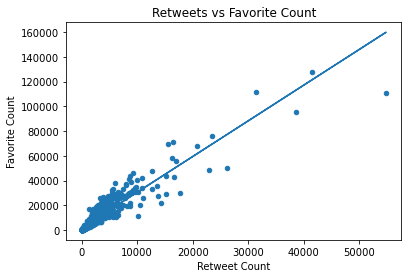

In [1140]:
x = merged.retweet_count
y = merged.favorite_count

merged.plot(x='retweet_count', y='favorite_count', kind='scatter');
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b)
plt.ylabel('Favorite Count')
plt.xlabel('Retweet Count')
plt.title('Retweets vs Favorite Count');

#### There is a positive correlation between Retweets and Favorite count.

#### 2. Which top 5 dogs got the maximum retweets?

In [1141]:
df = merged.groupby('p1').retweet_count.sum().reset_index()
sort = df.sort_values('retweet_count', ascending = False).head(5)
sort

,p1,retweet_count
87,golden_retriever,319759.0
47,Pembroke,207444.0
35,Labrador_retriever,141940.0
53,Samoyed,85662.0
22,French_bulldog,83757.0


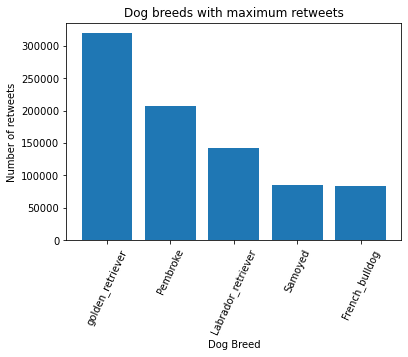

In [1142]:
plt.bar(sort.p1,sort.retweet_count)
plt.title('Dog breeds with maximum retweets')
plt.xlabel('Dog Breed')
plt.ylabel('Number of retweets');
plt.xticks(rotation=65);

#### Golden Retriever has the most number of retweets.

#### 3. Does the name of the dog relate to more retweets?

In [1143]:
df = merged.groupby('name').retweet_count.sum().reset_index()
df.head()

,name,retweet_count
0,Abby,581.0
1,Acro,278.0
2,Adele,687.0
3,Aiden,588.0
4,Aja,16409.0


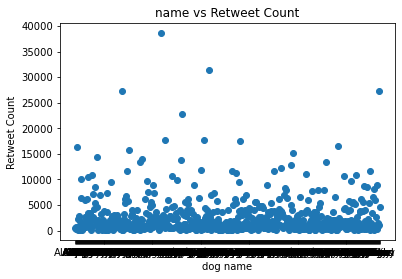

In [1144]:
plt.scatter(df.name, df.retweet_count)
plt.xlabel('dog name')
plt.ylabel('Retweet Count')
plt.title('name vs Retweet Count');

#### There is a negative correlation between name of the dog  and the retweets.

#### 4. Which dog names had the most retweets?

In [1145]:
sort = df.sort_values('retweet_count', ascending = False).head(10)
sort

,name,retweet_count
174,Duddles,38671.0
270,Jamesy,31332.0
94,Buddy,27373.0
614,Zoey,27235.0
215,Gary,22757.0
182,Earl,17698.0
260,Hurley,17625.0
333,Leo,17439.0
530,Stanley,16493.0
4,Aja,16409.0


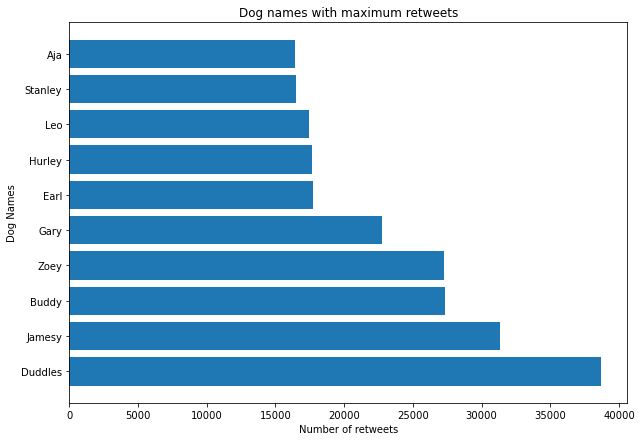

In [1146]:
plt.subplots(figsize=(10,7))
plt.barh(sort.name, sort.retweet_count)
plt.title('Dog names with maximum retweets')
plt.xlabel('Number of retweets')
plt.ylabel('Dog Names');


#### The dog name, Duddles has the most number of retweets.